# Impurity Level Estimator

## Section 1: Business Understanding

Measuring the impurity level in the product from a distillation column can be a time consuming process, and can result in production of off-spec (not within specifications) product before a problem is detected. Thus, there is a need for a quick and reliable method to measure or estimate the impurity level.

Distillation columns are often instrumented to measure flow rates and temperatures at multiple locations. These measurements are almost instantaneous. A model relating the impurity level to the temperature and flow measurements may provide a fast and acceptable solution for quickly estimating the impurity level.
### The questions of interest are:
<font color='red'>
    
1. Might it be possible to predict the impurity level using the other operating parameters?
    
2. What if some of the operating parameter measurements are occassionally unavailable?
    
3. Is the estimator good enough for deployment?
</font>

The following code develops a linear regression model of impurity as a function of column operating parametes (temperatures and flow rates) and makes an assessment of the model quality.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

In [2]:
# read data file. the first column is blank. read only columns B:T
df = pd.read_excel('./Distillation Data 2020-08-20 for Blog.xlsx', usecols='B:T')

# examine the first five rows
df.head()

,Reflux ratio,D/F,Pressure,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,Impurity
0,2.887537,0.403726,48.980834,NaN,NaN,100.268473,NaN,112.328178,120.827117,129.704816,NaN,149.658015,NaN,NaN,163.896582,166.574718,169.866201,NaN,0.011651
1,2.959575,0.389883,47.337787,NaN,94.812792,96.839901,NaN,NaN,112.085992,120.805074,NaN,141.281224,149.442104,155.274783,159.123603,161.893418,NaN,170.810737,0.007149
2,2.660605,0.418623,43.523609,83.951394,NaN,89.685128,94.648442,NaN,NaN,116.889379,125.914637,135.582649,143.128673,147.365776,149.532638,152.277614,NaN,156.723471,0.005780
3,2.781381,0.454618,46.675383,91.083622,96.518298,104.731650,115.339067,NaN,133.628745,138.957221,NaN,151.458543,155.504138,158.229142,159.971603,NaN,162.920535,165.800038,NaN
4,2.716885,0.437781,43.659927,NaN,83.925892,NaN,85.897024,NaN,NaN,99.793446,111.265397,NaN,126.147318,135.020133,142.614103,147.707465,152.792045,156.201534,-0.001702


## Section 2: Develop data understanding

Start off by creating a heat map to determine if the impurity level appears to have some relationship with the other operating parameters.

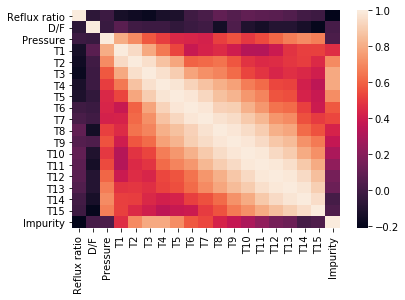

In [3]:
# create a heat map to find which variables are strongly correlated with the impurity
sns.heatmap(df.corr())

The impurity (bottom row in the heat map) has high correlation with T1 through T7, and low to no correlation with the remaining variables. This is consistent with distillation column behavior.

The temperatures (T1 through T15) and pressure have high to moderate correlations amongst themselves. This behavior could be useful for imputing missing temperature values, so T8-T15 will not be dropped from the data set even though they have low correlation with the impurity level. (Note: later in this project, missing values have been imputed using the mean, so the correlation amongst the temperature measuremnts has not been exploited for imputing missing values).

Based on these observations, it is reasonable to expect that a good model could be obtained, so let us proceed to the next step in the CRISP-DM process.

<font color='red'>
Answer to Question 1: It should be possible to predict the impurity level using the other operating parameters (yes, there is hope, but we don't yet know whether the model quality will be acceptable).
</font>

## Section3 : Prepare the data for analysis

First examine the data to get an idea of what is available and what is missing.

In [4]:
def display_information(df):
    '''Displays the statistics provided by the pandas .describe() method and the following
    number of rows in the dataframe
    number rows with all data missing
    additional information:
    percentage of missing values in each column
    percentage of positive values in each column
    percentage of zero values in each column
    percentage of negative values in each column
    data type of each column.'''
    
    # get statistics provided by pandas .describe() method
    info = df.describe()

    # add a row with the percentage of values that are missing in each column
    info.loc['Pct missing'] = df.isna().sum() / df.shape[0] * 100
    
    # add a row with the percentage of values that are positive in each column
    info.loc['Pct positive'] = (df > 0).sum() / df.shape[0] * 100
    
    # add a row with the percentage of values that are equal to zero in each column
    info.loc['Pct zero'] = (df == 0).sum() / df.shape[0] * 100
    
    # add a row with the percentage of values that are negative in each column
    info.loc['Pct negative'] = (df < 0).sum() / df.shape[0] * 100

    # add a row with the data type for each column
    info.loc['Data type'] = df.dtypes

    # print the information
    print('Total number of rows: {}'.format(df.shape[0]))
    print('Number of rows with all data missing: {}'.format(sum(df.isna().sum() == df.shape[0])))
    print('\n')
    print(info)


Test if the docstring works...

In [5]:
# test if the docstring works...
print(display_information.__doc__)

Displays the statistics provided by the pandas .describe() method and the following
    number of rows in the dataframe
    number rows with all data missing
    additional information:
    percentage of missing values in each column
    percentage of positive values in each column
    percentage of zero values in each column
    percentage of negative values in each column
    data type of each column.


Yes, the docstring works!

In [6]:
# get information about each data column
display_information(df)

Total number of rows: 200
Number of rows with all data missing: 0


             Reflux ratio        D/F Pressure       T1       T2       T3  \
count                 176        176      186      156      160      151   
mean              2.96782   0.396523  45.2063  89.8527  91.8269  94.5531   
std               0.27671  0.0387825  3.00479   4.8647  5.58278  6.49499   
min               2.53115   0.332041  40.1287  80.0574  82.8672  85.1742   
25%               2.73817      0.362  42.5746  85.8844  87.6643  90.0829   
50%               2.92008   0.392921  45.4917   89.625   91.426  94.0081   
75%               3.15138   0.429766  47.9113  93.2628  95.1841  97.7246   
max               3.49373   0.469918  49.9848  105.596  114.921   124.36   
Pct missing            12         12        7       22       20     24.5   
Pct positive           88         88       93       78       80     75.5   
Pct zero                0          0        0        0        0        0   
Pct negative        

Observations:

The following columns have 20% or more missing data: T1, T2, T3, T4, T5, T6, T8, T12. This indicates the need for maintenance/repair work on the corresponding instruments.

The maximum percentage of missing data in any one column is 25% (T3, T4, T8), but not necessarily at the same time. There are 200 rows and there are no rows that are missing all data. We will proceed with imputing the missing data - we never have to impute more that 25% of any column.

There are a few rows with a negative impurity level. This is bad data, and the corresponding rows should be deleted.

Each column is of type float, so we don't have a situation where strings appear to be numbers.

The remaining column means and ranges appear to be reasonable.

In [7]:
# remove rows (if any) that have with all missing values
df.dropna(axis=0, how='all', inplace=True)

# remove columns (if any) that have all missing values
# (no such columns in this example, but including the code for robustness)
df.dropna(axis=1, how='all', inplace=True)

# drop rows that have a missing value for impurity (can't model if the label is missing)
df.dropna(subset=['Impurity'], axis=0, inplace=True)

# the above statistics show some observations with negative impurity levels. 
# these should be treated as bad data and removed from the data set.
df = df[df['Impurity'] > 0]

# display statistics for each measurement
df.describe()

,Reflux ratio,D/F,Pressure,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,Impurity
count,151.000000,150.000000,159.000000,133.000000,139.000000,134.000000,129.000000,137.000000,142.000000,141.000000,131.000000,146.000000,150.000000,143.000000,140.000000,154.000000,142.000000,160.000000,173.000000
mean,2.972393,0.395426,45.099831,89.839414,91.807436,94.720716,99.658808,105.461689,112.798723,121.940995,129.234135,138.799011,145.373585,150.636454,154.823413,157.046866,159.048066,164.031735,0.015394
std,0.277654,0.038534,3.073496,4.962613,5.675205,6.557479,7.937679,9.197493,8.942656,8.859434,8.032545,8.542886,8.230005,7.891169,7.148064,6.706651,6.371452,7.470701,0.021141
min,2.531154,0.332698,40.128743,81.460222,83.650902,85.472536,86.664586,88.867503,93.032653,96.294694,99.975936,103.653712,106.789908,110.618707,115.085944,120.918759,129.046709,139.477227,0.001096
25%,2.737204,0.360749,42.425548,85.727697,87.659812,90.158521,93.830879,98.608883,105.927610,115.000803,123.460698,133.263643,140.456313,146.237766,150.662088,152.854635,154.953956,158.653588,0.006598
50%,2.936583,0.389061,45.186698,89.428599,91.086405,94.492067,98.760861,103.810090,112.433037,122.533099,129.878273,140.253144,146.396894,151.611266,155.110569,157.414876,159.027447,163.594432,0.009274
75%,3.151827,0.429053,48.005676,93.293177,95.058481,97.778664,103.464809,111.676833,119.022140,128.420010,134.890593,144.338975,151.307724,156.058731,159.882453,161.923730,164.051335,169.423523,0.015310
max,3.493731,0.469918,49.984843,105.596343,114.920984,124.359541,132.069831,137.412089,140.859925,143.412368,150.989362,158.971883,161.942997,166.194423,169.354312,171.556007,170.133244,183.463665,0.124914


Next,  impute missing values using the mean for each column.

In [8]:
# replace missing values with the mean for that column
fill_mean = lambda col: col.fillna(col.mean())
# Fill the mean
fill_mean_df = df.apply(fill_mean, axis=0)

In [9]:
fill_mean_df.describe()

,Reflux ratio,D/F,Pressure,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,Impurity
count,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000
mean,2.972393,0.395426,45.099831,89.839414,91.807436,94.720716,99.658808,105.461689,112.798723,121.940995,129.234135,138.799011,145.373585,150.636454,154.823413,157.046866,159.048066,164.031735,0.015394
std,0.259289,0.035865,2.945758,4.347435,5.083430,5.766317,6.847536,8.178520,8.096771,7.992926,6.983299,7.843762,7.660005,7.170035,6.425865,6.325389,5.768777,7.182832,0.021141
min,2.531154,0.332698,40.128743,81.460222,83.650902,85.472536,86.664586,88.867503,93.032653,96.294694,99.975936,103.653712,106.789908,110.618707,115.085944,120.918759,129.046709,139.477227,0.001096
25%,2.755919,0.368530,42.580549,86.758130,88.350612,91.415061,96.501099,99.474200,107.270100,116.506835,126.697886,135.274312,141.522243,147.094101,152.025145,153.094817,155.527734,159.061160,0.006598
50%,2.972393,0.395426,45.099831,89.839414,91.807436,94.720716,99.658808,105.461689,112.798723,121.940995,129.234135,138.799011,145.373585,150.636454,154.823413,157.046866,159.048066,164.031735,0.009274
75%,3.115072,0.421003,47.852122,92.301789,94.473368,96.701649,101.751517,109.391731,117.494268,127.396214,133.534936,143.875946,150.543185,154.993178,158.999844,161.591235,163.331015,169.279086,0.015310
max,3.493731,0.469918,49.984843,105.596343,114.920984,124.359541,132.069831,137.412089,140.859925,143.412368,150.989362,158.971883,161.942997,166.194423,169.354312,171.556007,170.133244,183.463665,0.124914


Each column has the same number of rows (200) as the original data set less the number of rows with missing Impurity, so the imputing of missing values was successful.

## Section 4: Model the data

In [10]:
# create as X all the columns except Impurity
X = fill_mean_df.drop(['Impurity'], axis=1)
    
# create as y the Impurity column
y = fill_mean_df['Impurity']

In [11]:
# instantiate a linear regression object
# normalized the data since the magnitudes of the measurements are different (temperatures are of the order of 100)
lm_model = LinearRegression(normalize=True)

In [12]:
# split the data set into a training set and a test set. set aside 30% of the data for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

In [13]:
# train the linear regression model
lm_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [14]:
# use the trained model to predict the test outputs
y_test_pred = lm_model.predict(X_test)

## Section 5: Evaluate the results to answer the questions of interest

In [15]:
# score the model on the training set
y_train_pred = lm_model.predict(X_train)
train_score = r2_score(y_train, y_train_pred)
train_score

0.8788577011602413

In [16]:
# score the model on the test set
test_score = r2_score(y_test, y_test_pred)
test_score

0.8163508010390117

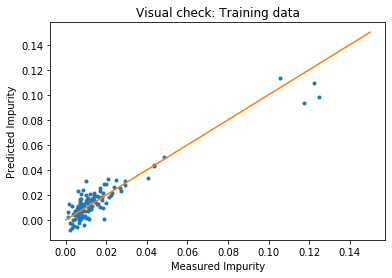

In [17]:
# a plot of the training set impurity versus the predicted training set impurity will help to spot problems
plt.plot(y_train, y_train_pred, '.')
plt.plot([0,0.15],[0,0.15])
plt.xlabel('Measured Impurity')
plt.ylabel('Predicted Impurity')
plt.title('Visual check: Training data')
plt.show()

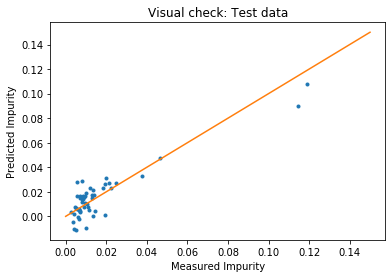

In [18]:
# a plot of the test set impurity versus the predicted test set impurity will help to spot problems
plt.plot(y_test, y_test_pred, '.')
plt.plot([0,0.15],[0,0.15])
plt.xlabel('Measured Impurity')
plt.ylabel('Predicted Impurity')
plt.title('Visual check: Test data')
plt.show()

Observations regarding model fit:

The R-squared is 0.88 for the training set and 0.82 for the test set. The test set fit would be considered “moderately good” for this particular application as the process would need to be operated with a sufficiently large cushion so that prediction errors would not result in off-spec product. However, increasing the operating cushion usually increases processing cost. A more accurate model (R-squared of 0.95) is desirable.

There appears to be a bias in the prediction of the test set. The model under-predicts at the upper end of the range for the training set and the test set. This also points to operating the process with a large cushion, and is undesirable.

### Now what? 
Here are some avenues for further exploration:
1. The problem lie with imputing missing values using the mean. Try other methods of imputing missing values - perhaps regress against other X variables;
2. These situations can sometimes be overcome by taking the log-transform of the impurity;
3. Try a more general non-linear model such as a neural net;
4. Use the current model for fast impurity estimation. Use a (slow but reliable) analyzer instrument to correct the linear model by offsetting the estimator value from time to time.

<font color='red'>
    
Answer to Question 1: It should be possible to predict the impurity level using the other operating parameters (yes, there is hope, but we don't yet know whether the model quality will be acceptable).
    
Answer to Question 2. Missing values can be replaced by mean values, but we don't know whether this is the best method.
    
Answer to Question 3: The model is no good enough for deployment.
</font>